In [7]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split

# Set device (GPU if available, else CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Define the transformations (Normalization)
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))  # Normalize the dataset to range [-1, 1]
])

In [8]:
# Load the MNIST dataset using sklearn digits

from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset

# Load the digits dataset (8x8 images of digits 0-9)
digits = load_digits()

# Get the data and target labels
X = digits.data  # Features (flattened 8x8 images = 64 features)
y = digits.target  # Target labels (0-9)

print(f"Dataset shape: {X.shape}")
print(f"Number of features: {X.shape[1]}")  # 64 features (8x8)
print(f"Number of classes: {len(np.unique(y))}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train)
y_train_tensor = torch.LongTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test)
y_test_tensor = torch.LongTensor(y_test)

# Create PyTorch datasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

print(f"Training samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")



Dataset shape: (1797, 64)
Number of features: 64
Number of classes: 10
Training samples: 1437
Test samples: 360


In [9]:
# Define the neural network model
class ANN(nn.Module):
    def __init__(self, input_size=64, hidden1=128, hidden2=64, output_size=10):
        super().__init__()
        # Define the layers (Fully Connected layers)
        self.fc1 = nn.Linear(input_size, hidden1)    # Input layer: 64 -> 128
        self.fc2 = nn.Linear(hidden1, hidden2)       # Hidden layer: 128 -> 64
        self.fc3 = nn.Linear(hidden2, output_size)   # Output layer: 64 -> 10
        
        # Dropout for regularization
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        # Forward pass through the network
        x = torch.relu(self.fc1(x))      # First layer + ReLU activation
        x = self.dropout(x)              # Dropout for regularization
        x = torch.relu(self.fc2(x))      # Second layer + ReLU activation
        x = self.dropout(x)              # Dropout for regularization
        x = self.fc3(x)                  # Output layer (no activation for classification)
        return x

In [10]:
# Initialize the model, loss function, and optimizer
model = ANN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Training the model
num_epochs = 50
train_losses = []
train_accuracies = []

print("Starting training...")
for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        # Move data to device
        data, target = data.to(device), target.to(device)
        
        # Zero the parameter gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(data)
        loss = criterion(outputs, target)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        # Statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()
    
    # Calculate epoch statistics
    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100 * correct / total
    
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc)
    
    # Print progress every 10 epochs
    if (epoch + 1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.2f}%')

print("Training completed!")


Starting training...
Epoch [10/50], Loss: 0.1167, Accuracy: 96.59%
Epoch [20/50], Loss: 0.0457, Accuracy: 98.75%
Epoch [30/50], Loss: 0.0309, Accuracy: 99.23%
Epoch [40/50], Loss: 0.0188, Accuracy: 99.72%
Epoch [50/50], Loss: 0.0203, Accuracy: 99.51%
Training completed!


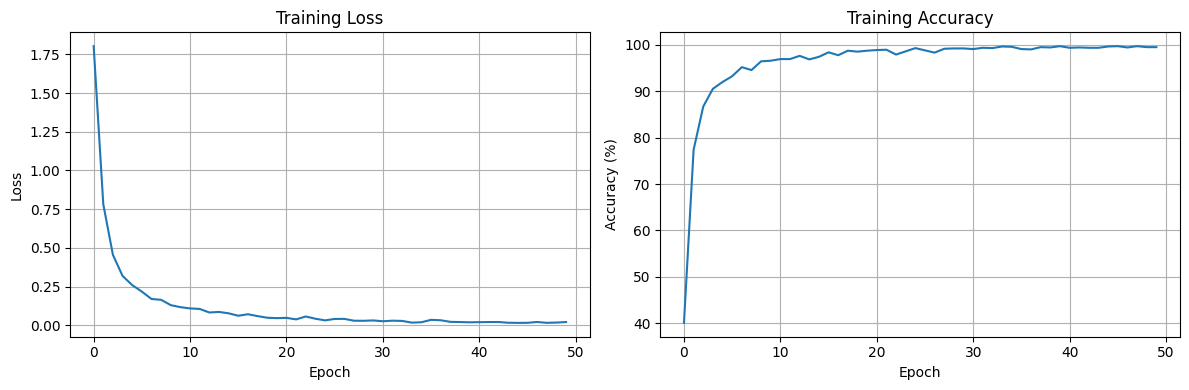

In [12]:
# Plot training progress
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot training loss
ax1.plot(train_losses)
ax1.set_title('Training Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.grid(True)

# Plot training accuracy
ax2.plot(train_accuracies)
ax2.set_title('Training Accuracy')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.grid(True)

plt.tight_layout()
plt.show()


In [13]:
# Testing the model
model.eval()  # Set the model to evaluation mode
all_preds = []
all_labels = []

with torch.no_grad():
    correct = 0
    total = 0
    for data, labels in test_loader:
        # Move data and labels to the device
        data = data.to(device)
        labels = labels.to(device)

        # Forward pass through the model
        outputs = model(data)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append predictions and labels for metrics
        all_preds.extend(predicted.cpu().numpy())  # Append predictions to the list
        all_labels.extend(labels.cpu().numpy())    # Append actual labels to the list

    print(f'Accuracy of the network on the test images: {100 * correct / total:.2f}%')

Accuracy of the network on the test images: 98.06%


In [14]:
# Calculate detailed metrics
# Convert predictions and labels to numpy arrays for metric calculation
all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# Calculate accuracy, precision, recall, and F1-score
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='weighted')
recall = recall_score(all_labels, all_preds, average='weighted')
f1 = f1_score(all_labels, all_preds, average='weighted')

print(f'Detailed Metrics:')
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1-Score: {f1:.4f}')

Detailed Metrics:
Accuracy: 98.06%
Precision: 0.9811
Recall: 0.9806
F1-Score: 0.9804


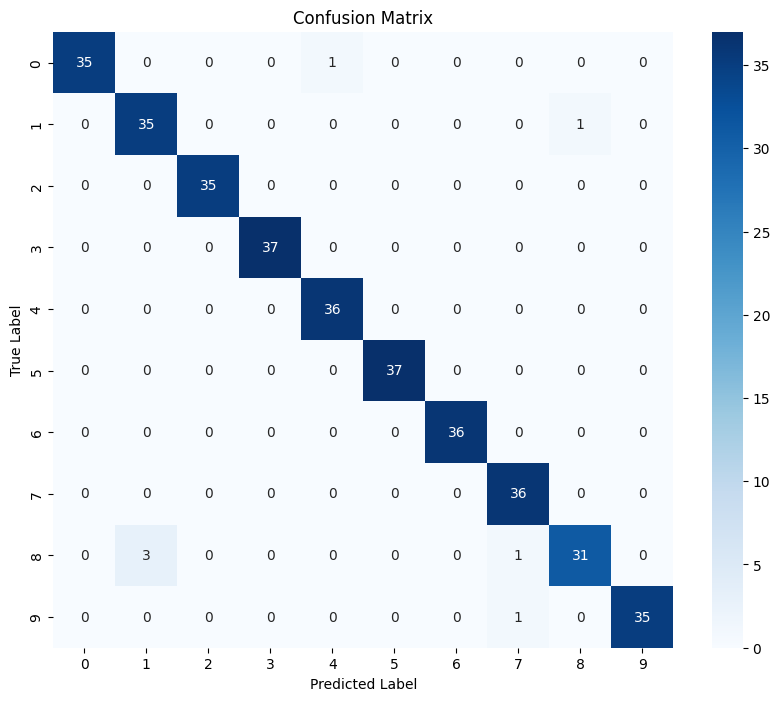


Confusion Matrix Summary:
Total test samples: 360
Correctly classified: 353
Misclassified: 7


In [15]:
# Confusion matrix visualization
conf_matrix = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Print confusion matrix summary
print(f'\nConfusion Matrix Summary:')
print(f'Total test samples: {len(all_labels)}')
print(f'Correctly classified: {np.sum(np.diag(conf_matrix))}')
print(f'Misclassified: {len(all_labels) - np.sum(np.diag(conf_matrix))}')